In [1]:
%matplotlib inline

In [2]:
%cd D:\materialy_pwr\7sem\app
MODULE_PATH = ".\cocoapi\PythonAPI\pycocotools\__init__.py"
MODULE_NAME = "pycocotools"
import importlib
import sys
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import json
import time
import cv2 as cv
import imgaug.augmenters as iaa
from PIL import Image, ImageDraw
import os.path


ROOT_DIR = os.path.abspath("./Mask_RCNN/")
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
import mrcnn.utils as utils
from mrcnn.config import Config

class MaskRCNNModule:

    def __init__(self, path_to_wages):

        sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
        MODEL_DIR = os.path.join(ROOT_DIR, "logs")

        class InferenceConfig(Config):
            NAME = "tomato"
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
            NUM_CLASSES = 2 + 1  # background + 2
            LEARNING_RATE = 0.001
            IMAGE_MIN_DIM = 720
            IMAGE_MAX_DIM = 1280
            STEPS_PER_EPOCH = 180
            VALIDATION_STEPS = 5
            BACKBONE = 'resnet101'
            RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
            TRAIN_ROIS_PER_IMAGE = 32
            MAX_GT_INSTANCES = 50
            POST_NMS_ROIS_INFERENCE = 500
            POST_NMS_ROIS_TRAINING = 1000

        inference_config = InferenceConfig()

        self.model = modellib.MaskRCNN(mode="inference",
                                  config=inference_config,
                                  model_dir=MODEL_DIR)

        print("Loading weights from ", path_to_wages)
        self.model.load_weights(path_to_wages, by_name=True)

    def detect(self, frame, plot, only_bbox = True):
        start_time = time.time()
        print("start detect ")
        results = self.model.detect([frame], verbose=1)
        end_time = time.time()
        r = results[0]
        print("Frame detection time: {}s".format(end_time - start_time))

        visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'],
                                    ["background", "tomato", "unripe tomato"], r['scores'], ax = plot, show_mask=False)



class YoloV3Module:
    def __init__(self, classes_path, config_path, weight_path):
        self.c_threshold = 0.5 # set threshold for bounding box values
        self.nms = 0.4 # set threshold for non maximum supression
        self.width = 416  # width of input image
        self.height = 416 # height of input image

        self.classesFile = classes_path  
        self.classes = None
        with open(self.classesFile, 'rt') as f:
            self.classes = f.read().rstrip('\n').split('\n')

        # initialize a list of colors to represent each possible class label
        self.COLORS = [(0,0,255),(0,51,25)]

        # PATH to weight and config files
        self.config = config_path 
        self.weight = weight_path 

        # Read the model using dnn
        self.net = cv.dnn.readNetFromDarknet(config, weight)

    def detect(self, frame, plot, only_bbox = True):
        image = frame
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        (H,W) = image.shape[:2]

        # Get the names of output layers
        ln = self.net.getLayerNames()
        ln = [ln[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]

        # generate blob for image input to the network
        blob = cv.dnn.blobFromImage(image,1/255,(416,416),swapRB=True, crop=False)
        self.net.setInput(blob)


        start = time.time()
        layersOutputs = self.net.forward(ln)
        end = time.time()

        # print the time required
        print( end- start)


        boxes = []
        confidences = []
        classIDs = []

        for output in layersOutputs:
            # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence (i.e., probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # filter out weak predictions by ensuring the detected
                # probability is greater than the minimum probability
                if confidence > self.c_threshold:

                    box = detection[0:4]* np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")

                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    # update our list of bounding box coordinates, confidences,
                    # and class IDs
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        # Remove unnecessary boxes using non maximum suppression
        idxs = cv.dnn.NMSBoxes(boxes, confidences, self.c_threshold, self.nms)

        if len(idxs) > 0:
            # loop over the indexes we are keeping
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])

                # draw a bounding box rectangle and label on the image
                color = [int(c) for c in self.COLORS[classIDs[i]]]
                cv.rectangle(image, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(self.classes[classIDs[i]], confidences[i])
                cv.putText(image, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX,
                    0.6, (255,255,255), 2)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plot.imshow(image)
        return image
    

D:\materialy_pwr\7sem\app


Using TensorFlow backend.


In [3]:
from skimage import data, io
from matplotlib import pyplot as plt
import pyrealsense2 as rs
import numpy as np
import cv2
import time

In [4]:
class Core:
    def __init__(self, model):
        self.model = model

    def runImage(self, path_to_image):
        image = io.imread(path_to_image)
        figsize = (13, 13)
        _, ax = plt.subplots(1, figsize=figsize)
        self.model.detect(image, ax)
        plt.show()

    def runVideo(self, path_to_video):
        pipeline = rs.pipeline()
        config = rs.config()
        rs.config.enable_device_from_file(config, path_to_video)
        colorizer = rs.colorizer()
        pipeline.start(config)
        #_, ax2 = plt.subplots(2, figsize=figsize)
        figsize = (13, 13)
        plt.ion()
        while True:
            frames = pipeline.wait_for_frames()
            _, ax = plt.subplots(1, figsize=figsize)
            depth_frame = frames.get_depth_frame()
            color_frame = frames.get_color_frame()
            color_image = np.asanyarray(color_frame.get_data())

            depth_color_frame = colorizer.colorize(depth_frame)
            depth_color_image = np.asanyarray(depth_color_frame.get_data())

            self.model.detect(color_image, ax)
            plt.pause(0.1)


    def runLive(self):
        pipeline = rs.pipeline()
        config = rs.config()

        config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 6)
        config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 6)

        # Start streaming

        ctx = rs.context()
        profile = ctx.devices[0]
        sensor_dep = profile.first_depth_sensor()
        sensor_color = profile.first_color_sensor()

        print("Exposure settings -> need to adjust to environment")
        sensor_dep.set_option(rs.option.enable_auto_exposure, 0)
        sensor_color.set_option(rs.option.enable_auto_exposure, 0)
        sensor_dep.set_option(rs.option.exposure, 800)
        sensor_color.set_option(rs.option.exposure, 70)

        print("exposure depth: %d" % sensor_dep.get_option(rs.option.exposure))
        print("exposure color: %d" % sensor_color.get_option(rs.option.exposure))
        depth_scale = sensor_dep.get_depth_scale()
        print("Depth Scale is: ", depth_scale)

        sensor_dep.set_option(rs.option.gain, 16)
        sensor_color.set_option(rs.option.brightness, 0)
        sensor_color.set_option(rs.option.contrast, 50)
        sensor_color.set_option(rs.option.hue, 0)
        sensor_color.set_option(rs.option.brightness, 0)
        sensor_color.set_option(rs.option.saturation, 64)
        sensor_color.set_option(rs.option.sharpness, 50)

        profile = pipeline.start(config)
        figsize = (13, 13)
        _, ax = plt.subplots(1, figsize=figsize)

        while True:
            frames = pipeline.wait_for_frames()
            _, ax = plt.subplots(1, figsize=figsize)
            raw_depth_frame = frames.get_depth_frame()
            raw_color_frame = frames.get_color_frame()

            spatial = rs.spatial_filter()
            spatial.set_option(rs.option.filter_magnitude, 2)
            spatial.set_option(rs.option.filter_smooth_alpha, 0.5)
            spatial.set_option(rs.option.filter_smooth_delta, 20)
            depth_frame = spatial.process(raw_depth_frame)
            temporal = rs.temporal_filter()
            temporal.set_option(rs.option.filter_smooth_alpha, 0.4)
            temporal.set_option(rs.option.filter_smooth_delta, 20)
            depth_frame = temporal.process(depth_frame)
            hole_filling = rs.hole_filling_filter()
            depth_frame = hole_filling.process(depth_frame)

            colorizer = rs.colorizer()
            depth_color_frame = colorizer.colorize(depth_frame)
            depth_image = np.asanyarray(depth_color_frame.get_data())
            color_image = np.asanyarray(raw_color_frame.get_data())

            self.model.detect(color_image, ax)
            plt.pause(0.1)

0.3939962387084961


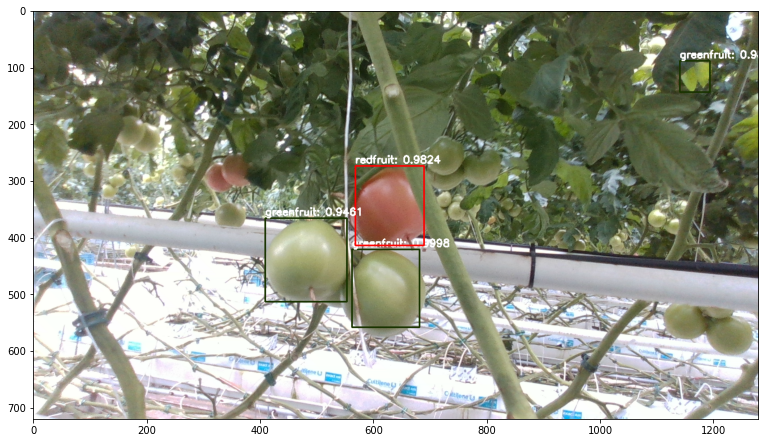

In [5]:
base = "D:\\materialy_pwr\\7sem\\tomato_own_dataset\\dataset_coco\\yolo\\"
classes = base + "coco.names"
config = base + 'yolov3_tomato_owndataset.cfg'
weight = base + 'yolov3_tomato_RGB_first_last.weights'
model = YoloV3Module(classes, config, weight)
yolo_core = Core(model)
yolo_core.runImage("D:\\materialy_pwr\\7sem\\tomato_own_dataset\\dataset_coco\\train\\" + "tomato_2021_08_06_11_04_07046309.png")

Loading weights from  D:\materialy_pwr\7sem\app\mask_rcnn_tomato_0040.h5
start detect 
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  int32
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32
Frame detection time: 2.1718387603759766s


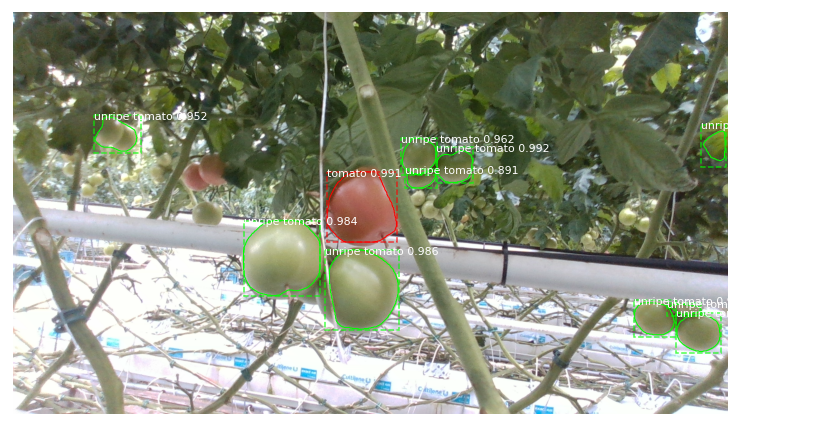

In [10]:
model = MaskRCNNModule(path_to_wages='D:\\materialy_pwr\\7sem\\app\\mask_rcnn_tomato_0040.h5')
core = Core(model)
core.runImage("D:\\materialy_pwr\\7sem\\tomato_own_dataset\\dataset_coco\\train\\" + "tomato_2021_08_06_11_04_07046309.png")

start detect 
Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  int32
anchors                  shape: (1, 409200, 4)        min:   -0.07077  max:    1.02073  float32
Frame detection time: 0.7066504955291748s


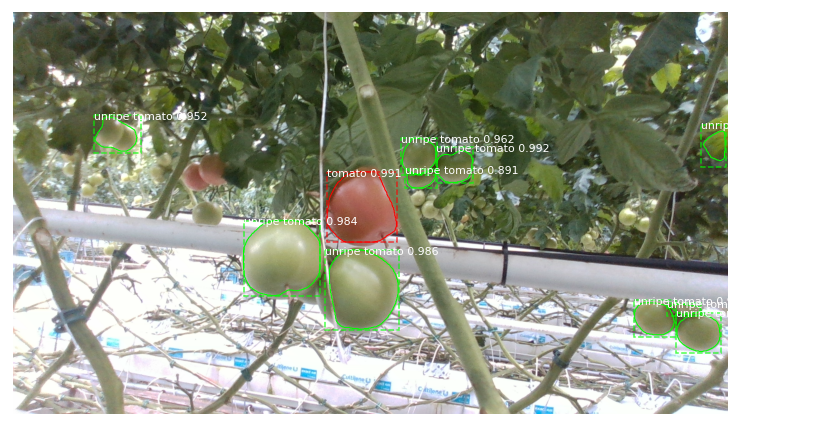

In [12]:
core.runImage("D:\\materialy_pwr\\7sem\\tomato_own_dataset\\dataset_coco\\train\\" + "tomato_2021_08_06_11_04_07046309.png")

In [8]:
import os
import glob
import re
from pathlib import Path
import numpy as np
%cd D:\\materialy_pwr\\7sem\\app\\models\\research\\object_detection
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
from collections import defaultdict
from io import StringIO
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

class SSDModule:
    def __init__(self, pb_file_path):

        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(pb_file_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
    
    def detect(self, image, plot):
        output_dict = []
        with self.detection_graph.as_default():
            with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()

                all_tensor_names = {
                    output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                    'num_detections', 'detection_boxes', 'detection_scores',
                    'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                            tensor_name)
                if 'detection_masks' in tensor_dict:
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(
                        tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(
                        tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(
                        tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                               real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                               real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)
                image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

                # Run inference
                output_dict = sess.run(tensor_dict,
                                       feed_dict={image_tensor: np.expand_dims(image, 0)})

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(
                    output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = output_dict['detection_scores'][0]
                if 'detection_masks' in output_dict:
                    output_dict['detection_masks'] = output_dict['detection_masks'][0]
        return output_dict

D:\materialy_pwr\7sem\app\models\research\object_detection


<Figure size 432x288 with 0 Axes>

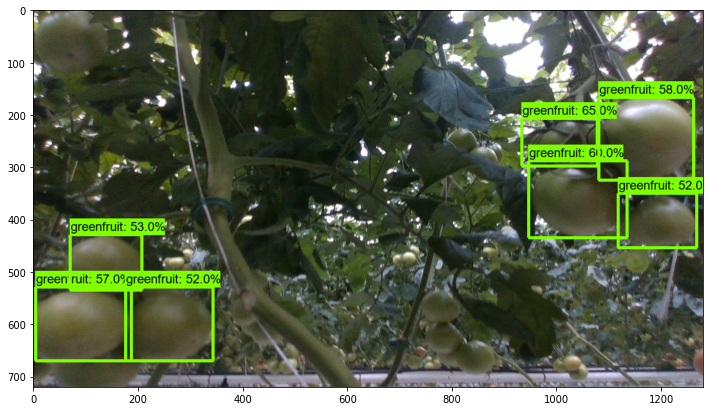

In [9]:
module = SSDModule(os.path.join("D:\\materialy_pwr\\7sem\\app", "ssd_own_dataset1.pb"))


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
    (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
        
%matplotlib inline
category_index = {1: {'id': 1, 'name': 'greenfruit'}, 2: {'id': 2, 'name': 'redfruit'}}
TEST_IMAGE_PATHS = ['D:\\materialy_pwr\\7sem\\tomato_own_dataset\\color\\tomato_2021_08_06_11_34_33539920.png']
axes1 = []

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = module.detect(image_np, axes1)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=6)
    plt.clf()
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

In [ ]:
import os
import glob
import re
from pathlib import Path
from pathlib import Path
import numpy as np

PATH_TO_CKPT = os.path.join("D:\\materialy_pwr\\7sem\\app", "ssd_own_dataset1.pb")

%cd D:\\materialy_pwr\\7sem\\app\\models\\research\\object_detection
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
from collections import defaultdict
from io import StringIO

# This is needed to display the images.
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




In [ ]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict



In [ ]:
TEST_IMAGE_PATHS = ['D:\\materialy_pwr\\7sem\\tomato_own_dataset\\color\\tomato_2021_08_06_11_34_33539920.png']
category_index = {1: {'id': 1, 'name': 'greenfruit'}, 2: {'id': 2, 'name': 'redfruit'}}
print(category_index)
for image_path in TEST_IMAGE_PATHS:

    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.clf()
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

In [ ]:
core.runVideo("D:\\materialy_pwr\\7sem\\tomato_own_dataset\\video\\fifth.bag")

In [ ]:
path_to_image = "RealSense_T20190528_230215_R02_P008860_H1630_A+000_RGB.tiff"
image = io.imread(path_to_image)
figsize = (13, 13)
_, ax = plt.subplots(1, figsize=figsize)
model.detect(image, ax)
plt.show()

In [ ]:
%cd D:\materialy_pwr\7sem\app
MODULE_PATH = ".\cocoapi\PythonAPI\pycocotools\__init__.py"
MODULE_NAME = "pycocotools"
import importlib
import sys
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module
spec.loader.exec_module(module)
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import json
import time
import cv2 as cv
import imgaug.augmenters as iaa
from PIL import Image, ImageDraw
import os.path
import glob
import re
from pathlib import Path
import six.moves.urllib as urllib
import tarfile
import tensorflow as tf
import zipfile
import matplotlib.pyplot as plt
from PIL import Image

ROOT_DIR = os.path.abspath("./Mask_RCNN/")
sys.path.append(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
import mrcnn.utils as utils
from mrcnn.config import Config


%cd D:\\materialy_pwr\\7sem\\app\\models\\research\\object_detection
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
from collections import defaultdict
from io import StringIO

class MaskRCNNModule:

    def __init__(self, path_to_wages):

        sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
        MODEL_DIR = os.path.join(ROOT_DIR, "logs")

        class InferenceConfig(Config):
            NAME = "tomato"
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
            NUM_CLASSES = 2 + 1  # background + 2
            LEARNING_RATE = 0.001
            IMAGE_MIN_DIM = 720
            IMAGE_MAX_DIM = 1280
            STEPS_PER_EPOCH = 180
            VALIDATION_STEPS = 5
            BACKBONE = 'resnet101'
            RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
            TRAIN_ROIS_PER_IMAGE = 32
            MAX_GT_INSTANCES = 50
            POST_NMS_ROIS_INFERENCE = 500
            POST_NMS_ROIS_TRAINING = 1000

        inference_config = InferenceConfig()

        self.model = modellib.MaskRCNN(mode="inference",
                                  config=inference_config,
                                  model_dir=MODEL_DIR)

        print("Loading weights from ", path_to_wages)
        self.model.load_weights(path_to_wages, by_name=True)

    def detect(self, frame, plot, only_bbox = True):
        start_time = time.time()
        print("start detect ")
        results = self.model.detect([frame], verbose=1)
        end_time = time.time()
        r = results[0]
        print("Frame detection time: {}s".format(end_time - start_time))

        visualize.display_instances(frame, r['rois'], r['masks'], r['class_ids'],
                                    ["background", "tomato", "unripe tomato"], r['scores'], ax = plot, show_mask=False)



class YoloV3Module:
    def __init__(self, classes_path, config_path, weight_path):
        self.c_threshold = 0.5 # set threshold for bounding box values
        self.nms = 0.4 # set threshold for non maximum supression
        self.width = 416  # width of input image
        self.height = 416 # height of input image

        self.classesFile = classes_path  
        self.classes = None
        with open(self.classesFile, 'rt') as f:
            self.classes = f.read().rstrip('\n').split('\n')

        # initialize a list of colors to represent each possible class label
        self.COLORS = [(0,0,255),(0,51,25)]

        # PATH to weight and config files
        self.config = config_path 
        self.weight = weight_path 

        # Read the model using dnn
        self.net = cv.dnn.readNetFromDarknet(config, weight)

    def detect(self, frame, plot, only_bbox = True):
        image = frame
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        (H,W) = image.shape[:2]

        # Get the names of output layers
        ln = self.net.getLayerNames()
        ln = [ln[i[0] - 1] for i in self.net.getUnconnectedOutLayers()]

        # generate blob for image input to the network
        blob = cv.dnn.blobFromImage(image,1/255,(416,416),swapRB=True, crop=False)
        self.net.setInput(blob)


        start = time.time()
        layersOutputs = self.net.forward(ln)
        end = time.time()

        # print the time required
        print( end- start)


        boxes = []
        confidences = []
        classIDs = []

        for output in layersOutputs:
            # loop over each of the detections
            for detection in output:
                # extract the class ID and confidence (i.e., probability) of
                # the current object detection
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # filter out weak predictions by ensuring the detected
                # probability is greater than the minimum probability
                if confidence > self.c_threshold:

                    box = detection[0:4]* np.array([W, H, W, H])
                    (centerX, centerY, width, height) = box.astype("int")

                    # use the center (x, y)-coordinates to derive the top and
                    # and left corner of the bounding box
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))

                    # update our list of bounding box coordinates, confidences,
                    # and class IDs
                    boxes.append([x, y, int(width), int(height)])
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        # Remove unnecessary boxes using non maximum suppression
        idxs = cv.dnn.NMSBoxes(boxes, confidences, self.c_threshold, self.nms)

        if len(idxs) > 0:
            # loop over the indexes we are keeping
            for i in idxs.flatten():
                # extract the bounding box coordinates
                (x, y) = (boxes[i][0], boxes[i][1])
                (w, h) = (boxes[i][2], boxes[i][3])

                # draw a bounding box rectangle and label on the image
                color = [int(c) for c in self.COLORS[classIDs[i]]]
                cv.rectangle(image, (x, y), (x + w, y + h), color, 2)
                text = "{}: {:.4f}".format(self.classes[classIDs[i]], confidences[i])
                cv.putText(image, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX,
                    0.6, (255,255,255), 2)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plot.imshow(image)
        return image
    
class SSDModule:
    def __init__(self, pb_file_path):

        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(pb_file_path, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
    
    def detect(self, image, plot):
        output_dict = []
        with self.detection_graph.as_default():
            with tf.Session() as sess:
                # Get handles to input and output tensors
                ops = tf.get_default_graph().get_operations()

                all_tensor_names = {
                    output.name for op in ops for output in op.outputs}
                tensor_dict = {}
                for key in [
                    'num_detections', 'detection_boxes', 'detection_scores',
                    'detection_classes', 'detection_masks'
                ]:
                    tensor_name = key + ':0'
                    if tensor_name in all_tensor_names:
                        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                            tensor_name)
                if 'detection_masks' in tensor_dict:
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(
                        tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(
                        tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(
                        tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                               real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                               real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)
                image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

                # Run inference
                output_dict = sess.run(tensor_dict,
                                       feed_dict={image_tensor: np.expand_dims(image, 0)})

                # all outputs are float32 numpy arrays, so convert types as appropriate
                output_dict['num_detections'] = int(
                    output_dict['num_detections'][0])
                output_dict['detection_classes'] = output_dict[
                    'detection_classes'][0].astype(np.uint8)
                output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
                output_dict['detection_scores'] = output_dict['detection_scores'][0]
                if 'detection_masks' in output_dict:
                    output_dict['detection_masks'] = output_dict['detection_masks'][0]
        return output_dict



In [ ]:
module = SSDModule(os.path.join("D:\\materialy_pwr\\7sem\\app", "ssd_own_dataset1.pb"))


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
    (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
        
%matplotlib inline
category_index = {1: {'id': 1, 'name': 'greenfruit'}, 2: {'id': 2, 'name': 'redfruit'}}
TEST_IMAGE_PATHS = ['D:\\materialy_pwr\\7sem\\tomato_own_dataset\\color\\tomato_2021_08_06_11_34_33539920.png']
axes1 = []

for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    output_dict = module.detect(image_np, axes1)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=6)
    plt.clf()
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()